In [8]:
import torch


In [9]:
torch.cuda.is_available()

True

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim import Adam
from torch.utils.data import DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [17]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])


train_dataset = datasets.MNIST(root='/',
                               train=True,
                               transform=transforms,
                               download=True)
dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)

In [61]:
class generation(nn.Module):
    '''
    定义生成器
    '''
    def __init__(self,**kwargs):
        super(generation, self).__init__(**kwargs)
        self.main = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
            nn.Tanh()
        )

    def forward(self,x):
        x = self.main(x)
        x = x.view(-1 ,28,28,1)
        return x

In [62]:
class discriminator(nn.Module):
    '''
    定义判别器
    '''
    def __init__(self, **kwargs):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.main(x)
        return x

In [56]:
def gen_img_plot(model,test_input):
    '''
    画图函数，每一个epoch训练，通过生成器生成16幅图片，并且对图片进行可是化
    '''
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i]+1)/2)
        plt.axis('off')
    plt.show()

In [52]:
inupt_test = torch.randn(16,100,device=device)
inupt_test1 = torch.randn(1,100,device=device)

Epoch: 0


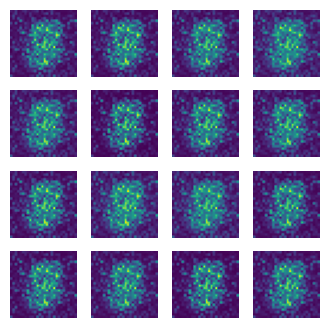

Epoch: 1


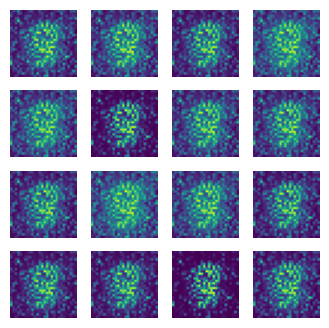

Epoch: 2


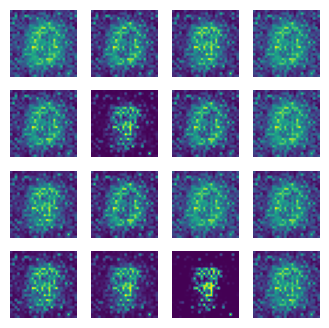

Epoch: 3


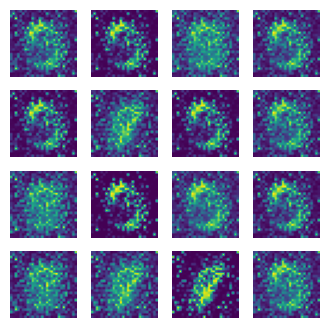

Epoch: 4


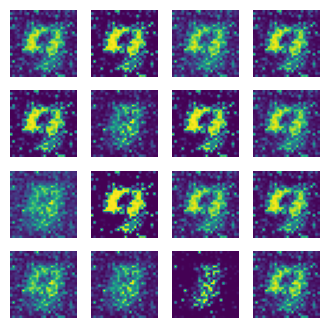

Epoch: 5


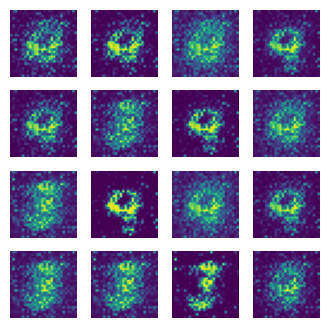

Epoch: 6


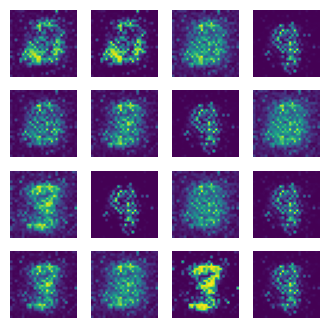

Epoch: 7


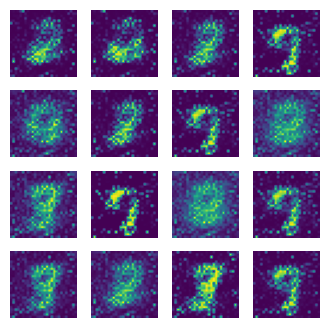

Epoch: 8


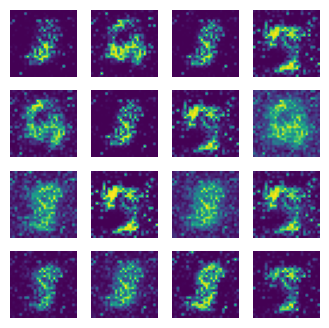

Epoch: 9


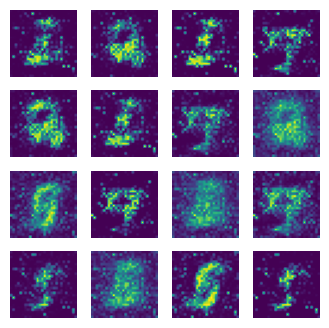

Epoch: 10


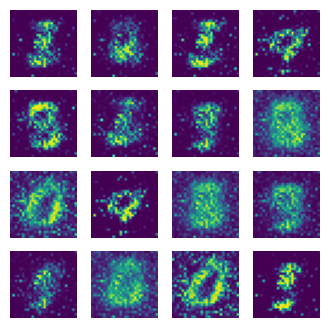

Epoch: 11


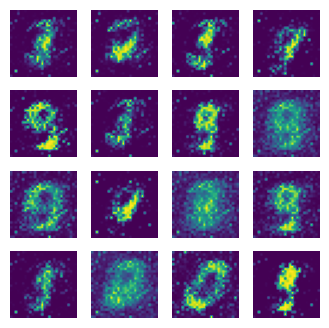

Epoch: 12


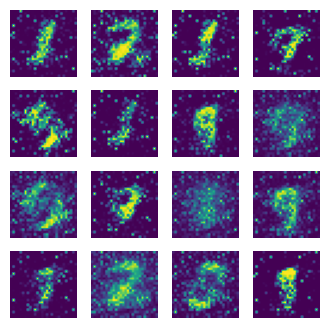

Epoch: 13


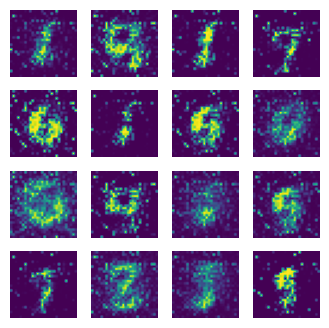

Epoch: 14


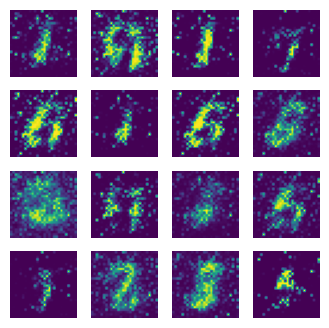

Epoch: 15


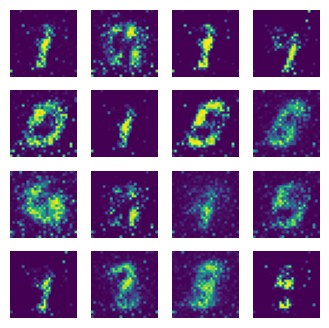

Epoch: 16


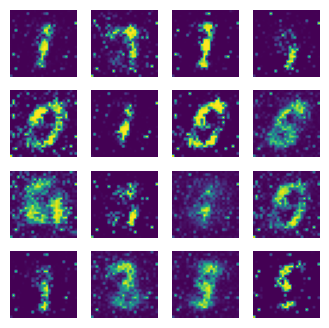

Epoch: 17


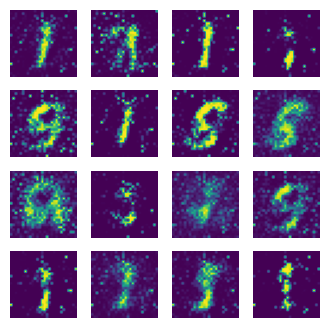

Epoch: 18


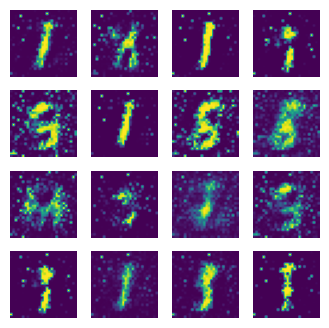

Epoch: 19


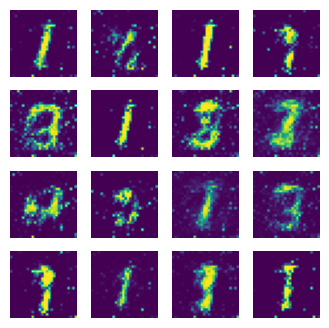

Epoch: 20


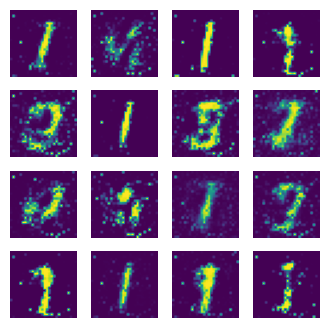

Epoch: 21


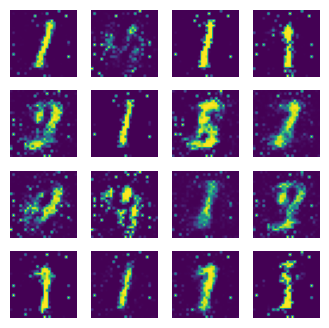

Epoch: 22


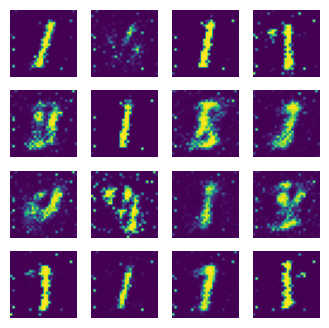

Epoch: 23


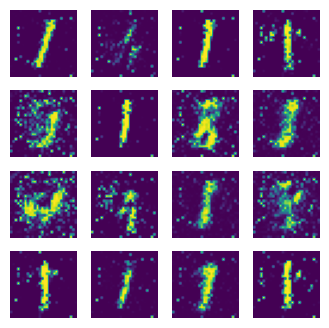

Epoch: 24


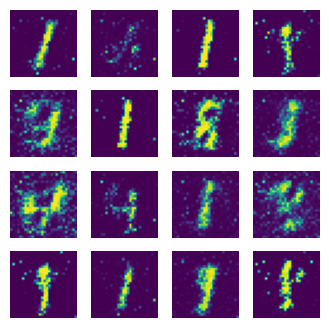

Epoch: 25


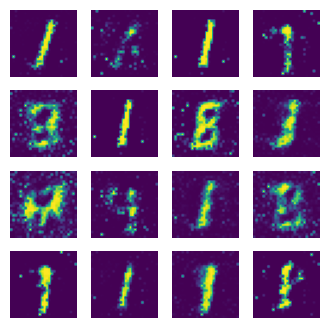

Epoch: 26


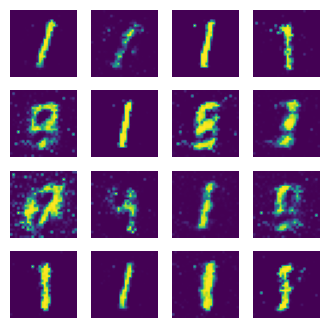

Epoch: 27


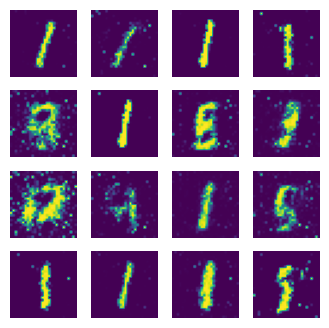

Epoch: 28


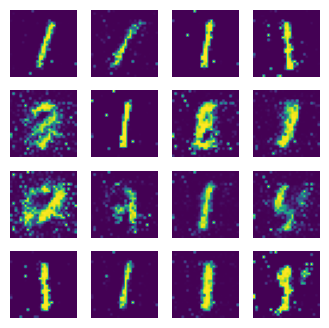

Epoch: 29


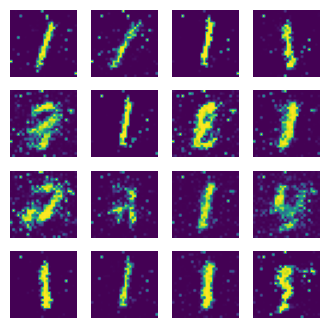

Epoch: 30


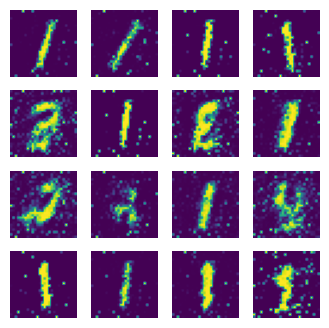

Epoch: 31


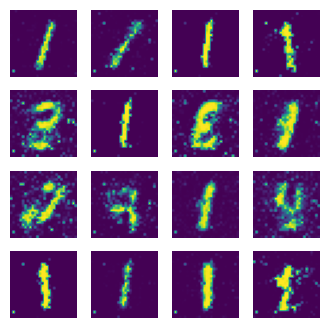

Epoch: 32


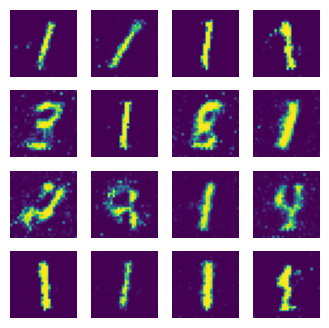

Epoch: 33


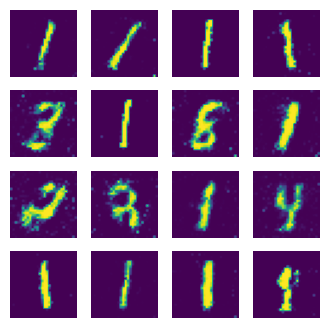

Epoch: 34


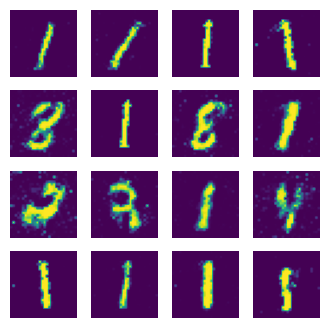

Epoch: 35


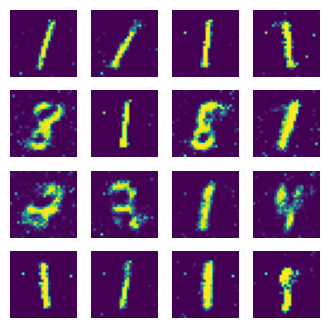

Epoch: 36


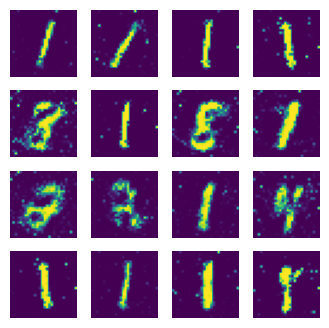

Epoch: 37


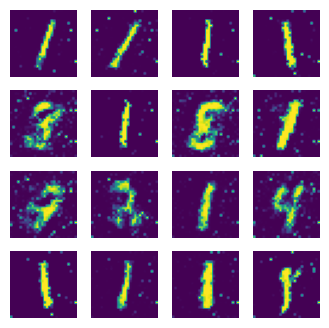

Epoch: 38


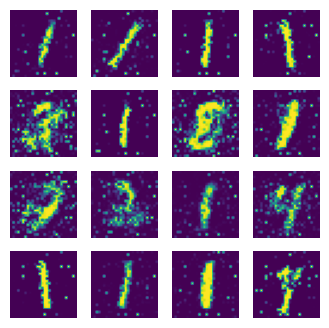

Epoch: 39


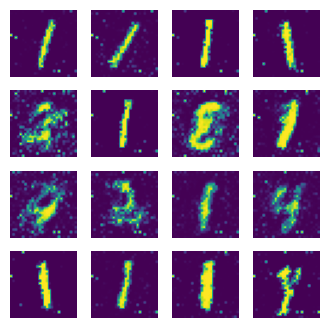

Epoch: 40


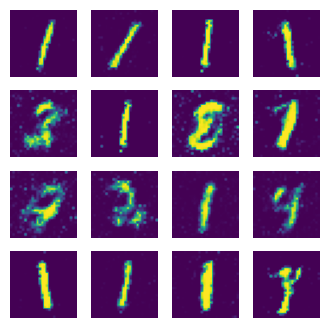

Epoch: 41


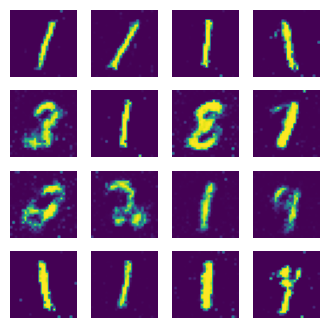

Epoch: 42


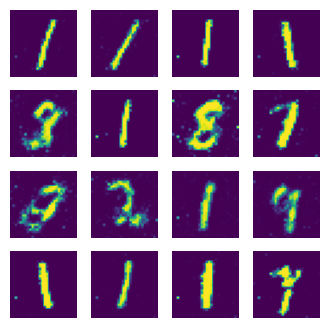

Epoch: 43


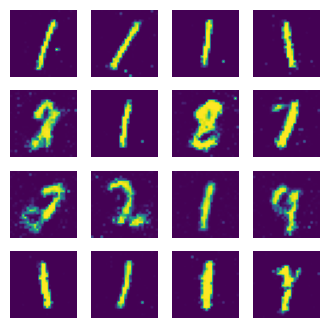

Epoch: 44


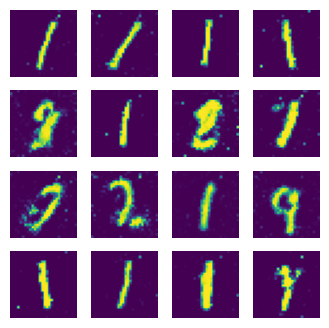

Epoch: 45


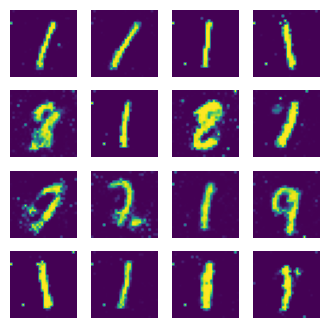

Epoch: 46


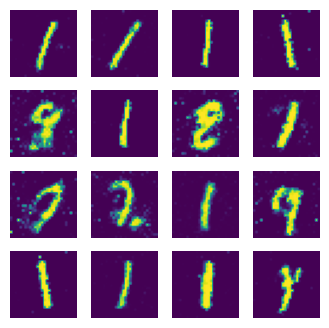

Epoch: 47


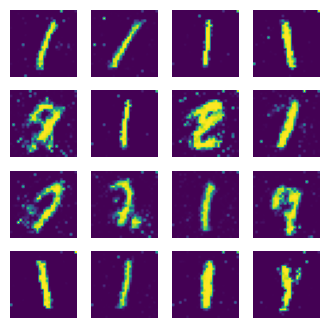

Epoch: 48


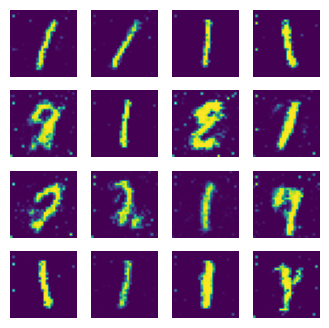

Epoch: 49


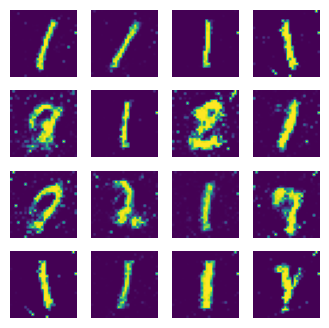

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = generation().to(device)
dis = discriminator().to(device)

dis_optim = Adam(dis.parameters(),lr = 0.0001)
gen_optim = Adam(gen.parameters(),lr = 0.0001)

#计算交叉熵损失函数
loss_fn = nn.BCELoss()
for epoch in range(50):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)
    for step ,(image , _) in enumerate(dataloader):
        image = image.to(device)
        size = image.size(0)
        random_noise = torch.randn(size,100,device=device)
        dis_optim.zero_grad()
        real_output = dis(image)
        #检测器对于真实数据的损失，期望对于真实数据的判别为1
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output),
                              )
        d_real_loss.backward()
        gen_image = gen(random_noise)
        fake_output = dis(gen_image.detach())
        #检测器对生成数据的判别，期望对于生成数据的判别为0
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(fake_output),
                              )
        d_fake_loss.backward()
        #最终判别器的loss包括两部分 一部分来自对生成数据的判别 损失一部分来自对真实数据的判别损失
        d_loss = d_fake_loss + d_real_loss
        dis_optim.step()
        gen_optim.zero_grad() #清除优化器中所有x的x梯度
        fake_output = dis(gen_image)
        #对于生成器损失，期望生成的数据被判别器判别为1
        g_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output),
                              )
        g_loss.backward() #进行反向传播
        gen_optim.step() #优化器对x的值进行更新

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
    D_loss = []
    G_loss = []
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        print('Epoch:', epoch)
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        gen_img_plot(gen,inupt_test)